In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import util

In [6]:
from sklearn import preprocessing 
from sklearn.metrics import pairwise 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 
from sklearn.cluster import KMeans 
from pandas.plotting import parallel_coordinates
from kmodes.kmodes import KModes

In [9]:
ksi_df = pd.read_csv('Data/KSI.csv')

In [4]:
pd.set_option('max_columns', None)

In [5]:
ksi_df = ksi_df.iloc[ksi_df['ACCNUM'].drop_duplicates().index]

In [11]:
ksi_df['INVTYPE'].str.contains('Driver')

0         True
1        False
2         True
3         True
4         True
         ...  
16855    False
16856     True
16857     True
16858    False
16859     True
Name: INVTYPE, Length: 16860, dtype: bool

In [13]:
# subset drivers so that only drivers are included

ksi_df = ksi_df[ksi_df['INVTYPE'].str.contains('Driver')]

In [19]:
ksi_df['LIGHT'] = ksi_df['LIGHT'].apply(util.lc)
ksi_df['TRAFFCTL'] = ksi_df['TRAFFCTL'].apply(util.tc)
ksi_df['DRIVACT'] = ksi_df['DRIVACT'].apply(util.actc)
ksi_df['DRIVCOND'] = ksi_df['DRIVCOND'].apply(util.condc)
ksi_df['VEHTYPE'] = ksi_df['VEHTYPE'].apply(util.vehc)
ksi_df['INVAGE'] = ksi_df['INVAGE'].apply(util.agec)

In [28]:
cols = ['VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'TRAFFCTL', 'PEDACT', 'PEDCOND', 'ROAD_CLASS', 'DISTRICT', 'SPEEDING', 'ALCOHOL', 'REDLIGHT', 'AG_DRIV', 'CYCACT', 'CYCCOND']

In [29]:
cluster_cols = ksi_df[cols]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 44226.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 44226.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 44226.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 44226.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 44226.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1171, cost: 41159.0
Run 1, iteration: 2/100, moves: 12, cost: 41159.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2613, cost: 40493.0
Run 2, iteration: 2

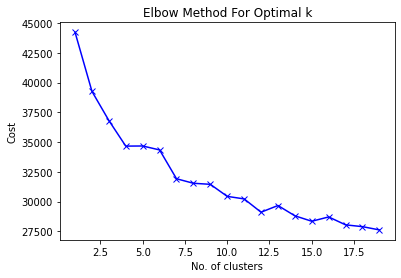

In [30]:
cost = []
K = range(1,20)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(cluster_cols)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [31]:
kmode = KModes(n_clusters= 10, init = "random", n_init = 5, verbose=0)
clusters = kmode.fit_predict(cluster_cols)

In [32]:
cluster_cols.insert(0, "Cluster", clusters, True)

In [33]:
cluster_cols

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
0,6,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Turning Left,Failed to Yield Right of Way,Unknown,Traffic Signal,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
2,5,Clear,Daylight,Dry,Turning Movement,Two Wheeler,Turning Right,Disobeyed Traffic Control,Unknown,Traffic Signal,<Null>,<Null>,Major Arterial,Scarborough,<Null>,<Null>,Yes,Yes,<Null>,<Null>
3,5,Clear,Daylight,Dry,Turning Movement,Small-size Vehicle,Going Ahead,Driving Properly,Unknown,Traffic Signal,<Null>,<Null>,Major Arterial,Scarborough,<Null>,<Null>,Yes,Yes,<Null>,<Null>
4,0,Clear,Dark,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Other,Ability Impaired (Drugs/Alcohol),No Control,<Null>,<Null>,Major Arterial,Scarborough,<Null>,Yes,<Null>,<Null>,<Null>,<Null>
7,8,Clear,Dark,Dry,Pedestrian Collisions,Small-size Vehicle,Turning Left,Failed to Yield Right of Way,Ability Impaired (Drugs/Alcohol),Traffic Signal,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,Yes,<Null>,Yes,<Null>,<Null>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16853,7,Clear,Daylight,Dry,Turning Movement,Two Wheeler,Going Ahead,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,North York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
16854,3,Clear,Daylight,Dry,Cyclist Collisions,Small-size Vehicle,Going Ahead,Improper Passing,Unknown,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
16856,6,Clear,Daylight,Dry,Turning Movement,Small-size Vehicle,Turning Left,Failed to Yield Right of Way,Inattentive,Traffic Signal,<Null>,<Null>,Major Arterial,Scarborough,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
16857,5,Clear,Daylight,Dry,Turning Movement,Small-size Vehicle,Going Ahead,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,Scarborough,<Null>,<Null>,<Null>,Yes,<Null>,<Null>


In [36]:
cluster_cols[cluster_cols['Cluster'] == 0]

,Cluster,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,TRAFFCTL,PEDACT,PEDCOND,ROAD_CLASS,DISTRICT,SPEEDING,ALCOHOL,REDLIGHT,AG_DRIV,CYCACT,CYCCOND
4,0,Clear,Dark,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Other,Ability Impaired (Drugs/Alcohol),No Control,<Null>,<Null>,Major Arterial,Scarborough,<Null>,Yes,<Null>,<Null>,<Null>,<Null>
9,0,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Driving Properly,Normal,Traffic Signal,<Null>,<Null>,Major Arterial,Etobicoke York,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
20,0,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Failed to Yield Right of Way,Normal,Pedestrian Crossover,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
22,0,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Failed to Yield Right of Way,Normal,Stop/Yield Sign,<Null>,<Null>,Collector,Toronto and East York,<Null>,<Null>,<Null>,Yes,<Null>,<Null>
24,0,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Driving Properly,Normal,No Control,<Null>,<Null>,Major Arterial,Toronto and East York,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16840,0,Clear,Daylight,Dry,Pedestrian Collisions,Small-size Vehicle,Going Ahead,Driving Properly,Normal,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
16844,0,Clear,Artificial,Dry,Cyclist Collisions,Large-size Vehicle,Going Ahead,Other,Unknown,Traffic Signal,<Null>,<Null>,Major Arterial,Scarborough,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
16846,0,Clear,Daylight,Dry,Cyclist Collisions,Small-size Vehicle,Stopped,Driving Properly,Normal,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
16849,0,Clear,Daylight,Dry,Cyclist Collisions,Small-size Vehicle,Turning Left,Driving Properly,Normal,No Control,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>,<Null>
